## Notebook Purpose

Previously was backpropagating on k-space using mse as loss function. This places very high emphasis on low frequency components.

--> How would IQ vary if we applied transforms to emphasize high-frequency components of k-space?

##### Need some non-linear transform to scale values

##### Scale pixel/k-space values? No
- Current scaling method:
    - create net_input ~U[0,1]
    - given randomly generated net, compute out_img
    - given slice_ksp, compute orig_img - i.e. ifft of very small k-space vals
    - scale_factor = norm(out_img) / norm(orig_img)
- FastMRI k-space data magnitude values are very small (pre-scale), w a handful of largest outlier values at 1e-3, but most, i.e. 99.9% are < 1e-5
- Conclusion: Scaling of values in k-space or image space shouldn't matter, i.e. 16-bit floating point precision can handle it regardless. Only want output values to be in same range for computing ssim, psnr, etc.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img, \
                            reshape_complex_channels_to_be_adj, \
                            combine_complex_channels
from utils.helpers import num_params, load_h5, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency, forwardm
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(3)
else:
    dtype = torch.FloatTensor

In [28]:
img_dc_list, img_est_list, img_gt_list, metrics_dc = [], [], [], []
mse_wrt_ksp_list, mse_wrt_img_list = [], []
ssim_list, psnr_list = [], []

file_id_list = ['1000464', '1000273', '1000007']#, '1000325']#, '1000537', '1000818', \
                #'1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
NUM_ITER = 1
DC_STEP = False

ni_list = []

for idx, file_id in enumerate(file_id_list):  

    f, slice_ksp = load_h5(file_id) # load full mri measurements
    print(slice_ksp.shape)
    mask, mask2d, mask1d = get_masks(f, slice_ksp) # load mask + variants, M
    mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # for dc step

    # initialize net, net input seed, and scale slice_ksp accordingly
    net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)
    ni_list.append(net)
    continue
    
    # for dc step - must do this after scaling slice_ksp
    ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype) #[1,15,640,368,2]

    # apply mask to measurements for fitting model
    ksp_masked, img_masked = get_masked_measurements(slice_ksp, mask)

    net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask2d,
        mask1d=mask1d_, ksp_orig=ksp_orig, DC_STEP=DC_STEP, alpha=0,#ALPHA,
        img_ls=None, num_iter=NUM_ITER, dtype=dtype)

    img_out = net(net_input.type(dtype))#[0] # estimate image \hat{x} = G(\hat{C})

    out_ksp_masked = forwardm(img_out, mask2d)

    img_dc, img_est = data_consistency(img_out[0], slice_ksp, mask1d)
    img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled

    _, _, ssim_, psnr_ = calc_metrics(img_dc, img_gt)

    # save images, metrics
    img_dc_list.append(img_dc)
    img_gt_list.append(img_gt) # could do this once per loop
    mse_wrt_ksp_list.append(mse_wrt_ksp)
    mse_wrt_img_list.append(mse_wrt_img)
    ssim_list.append(ssim_)
    psnr_list.append(psnr_)
    
#     ksp_masked_flat = ksp_masked.detach().cpu().numpy().flatten()
#     ksp_orig_flat = ksp_orig.detach().cpu().numpy().flatten()
#     val = 0.5
#     kmf = chop_tail(ksp_masked_flat, -val, val)
#     kof = chop_tail(ksp_orig_flat, -val, val)
#     print(len(kmf) / len(ksp_masked_flat), len(kof) / len(ksp_orig_flat))

    arr_km = combine_complex_channels(reshape_complex_channels_to_be_adj(ksp_masked[0].detach().cpu().numpy())).flatten()
#     io = img_out[0].detach().cpu().numpy().flatten()
#     io = combine_complex_channels(io)
#     arr_km = io
    ll = len(arr_km)
    (n, bins, patches) = plt.hist(arr_km, bins=100)
    plt.close()

    arr_km = chop_tail(arr_km, bins[0], bins[1])
    print(n[0] / ll)
    plt.hist(arr_km, bins=50)
    plt.show()

(15, 640, 368)
(15, 640, 368)
(15, 640, 368)


In [82]:
def chop_tail(arr, val_min, val_max):
    ''' given flat arr, remove elements not b/w val_min and val_max '''
    arr = arr.flatten()
    arr = arr[arr>val_min]
    return arr[arr<val_max]

7005380


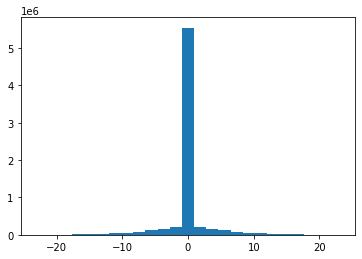

In [71]:
plt.hist(kmf_norm, bins=25)
print(len(kmf))
plt.show()